In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from algorithms.astar2k import astar2k
from algorithms.thetastar import thetastar
from algorithms.anya import anya
from util.structures import Map, Node, AnyaMap
from util.containers import Open, Closed
from util import functions as uf
from test import movingai_util as mutil
from draw.draw import draw
import random
import time
%matplotlib inline

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . # # . # # . . . . . . . . . 
. . . . . . . . . . . . . . . # . # . # . # . . . . . . . . 
. . . . . . . . . . . . . . . # # # # # # # . . . . . . . . 
. . . . . . . . . . . . . . . . . # . # . . . . . . . . . . 
. . . . . . . . . . . . . . . # # # # # # # . . . . . . . . 
. . . . . . . . . . . . . . . # . # . # . # . . . . . . . . 
. . . . . . . . . . . . . . . . # # . # # . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
test_get_neighbors: OK
test_compute_cost: OK


In [2]:
def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]

    if (task is None) or not (0 <= task < 25):
        task = random.randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    #try:
    if 1 != 2:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = uf.make_path(result[1])
            correct = int(path[1]) == int(length)
            draw(task_map, start, goal, path[0], *result[4:])
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Correct: " + str(correct))
        else:
            draw(task_map, start, goal, [start], *result[4:], *result[5:])
            print("Path not found!")
        return result

    #except Exception as e:
        print("Execution error")
        print(e)


In [3]:
def massive_test(search_function, heuristic_function, task_map, tasks, w=1, EPS=1e-6):
    corrected = 0
    results = np.zeros((3, len(tasks)))
    for i, (start_i, start_j, goal_i, goal_j, exp_len) in tqdm(enumerate(tasks)):
        try:
            result = search_function(task_map, start_i, start_j, goal_i, goal_j, heuristic_function, w)
            nodes_expanded = result[2]
            nodes_opened = result[3]
            if result[0]:
                path = uf.make_path(result[1])
                correct = abs(path[1] - exp_len) < EPS
                if correct:
                    corrected += 1
                d = path[1]
                if (exp_len > 0):
                    d /= exp_len
                results[0, i] = len(nodes_expanded)
                results[1, i] = d
                #print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodes_opened) + len(nodes_expanded)) + ". Number of steps: " + str(len(nodes_expanded)) + ". Correct: " + str(correct))
            #
                #print("Path not found!")
        except Exception as e:
            print("Execution error")
            print(e)

    print(f'Correct: {corrected} of {len(tasks)}')
    return results

In [4]:
def cities(heuristic_func):
    cities = ["Berlin_0_512", "Boston_0_512", "Denver_0_512", "London_0_512", "Milan_0_512", "Moscow_0_512", "NewYork_0_512", "Paris_0_512", "Shanghai_0_512", "Sydney_0_512"]
    df_time = pd.DataFrame(columns=["4-astar", "32-astar", "theta-star", "anya"])
    df_len = pd.DataFrame(columns=["4-astar", "32-astar", "theta-star", "anya"])
    df_len_o = pd.DataFrame(columns=["4-astar", "32-astar", "theta-star", "anya"])
    df_steps = pd.DataFrame(columns=["4-astar", "32-astar", "theta-star", "anya"])

    for city in cities:
        map_path = f"test/data/{city}.map"
        tasks_path = f"test/data/{city}.map.scen"
        task_map = mutil.read_map_from_movingai_file(map_path, AnyaMap)
        tasks = mutil.read_tasks_from_movingai_file(tasks_path)
        random.seed(50)
        random.shuffle(tasks)


        for i in tqdm(range(10)):
            (s_i, s_j, f_i, f_j, l) = tasks[i]
            start = Node(i = s_i, j = s_j)
            goal = Node(i = f_i, j = f_j)

            s_t = time.time()
            result4 = astar2k(task_map, start.i, start.j, goal.i, goal.j, heuristic_func, Open, Closed, k=2)
            t4 = time.time() - s_t
            s_t = time.time()
            result32 = astar2k(task_map, start.i, start.j, goal.i, goal.j, heuristic_func, Open, Closed, k=5)
            t32 = time.time() - s_t
            s_t = time.time()
            resulttheta = thetastar(task_map, start.i, start.j, goal.i, goal.j, heuristic_func, Open, Closed)
            tt = time.time() - s_t
            s_t = time.time()
            resultanya = anya(task_map, start.i, start.j, goal.i, goal.j, heuristic_func)
            ta = time.time() - s_t
            #number_of_steps = result[2]
            #nodes_created = result[3]
            l4 = -1
            l32 = -1
            ltheta = -1
            lanya = -1
            st4 = -1
            st32 = -1
            sttheta = -1
            stanya = -1
            if result4[0]:
                _, l4 = uf.make_path(result4[1])
                st4 = result4[2]
            if result32[0]:
                _, l32 = uf.make_path(result32[1])
                st32 = result32[2]
            if resulttheta[0]:
                _, ltheta = uf.make_path(resulttheta[1])
                sttheta = resulttheta[2]
            if resultanya[0]:
                _, lanya = uf.make_path(resultanya[1])
                stanya = resultanya[2]
            divi = lanya
            if divi == 0:
                print(start.i, start.j, goal.i, goal.j)
                continue
            df_len_o = df_len_o.append({"4-astar": l4 / lanya, "32-astar": l32 / lanya, "theta-star": ltheta / lanya, "anya": 1}, ignore_index=True)
            df_len = df_len.append({"4-astar": l4, "32-astar": l32, "theta-star": ltheta, "anya": lanya}, ignore_index=True)
            df_time = df_time.append({"4-astar": t4, "32-astar": t32, "theta-star": tt, "anya": ta}, ignore_index=True)
            df_steps = df_steps.append({"4-astar": st4, "32-astar": st32, "theta-star": sttheta, "anya": stanya}, ignore_index=True)
    return df_len_o, df_len, df_time, df_steps
    print("Lenghts / best length")
    display(df_len_o)
    print("Lenghts")
    display(df_len)
    print("Times")
    display(df_time)
    print("Steps")
    display(df_steps)

In [5]:
df_len_o, df_len, df_time, df_steps = cities(uf.euclidian_distance)

100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.19s/it]


In [12]:
print("Lenghts / best length")
display(df_len_o)
print("Lenghts")
display(df_len)
print("Times")
display(df_time)
print("Steps")
display(df_steps)

df_len_o.describe()
#df_len.describe()
#df_time.describe()
#df_steps.describe()

Lenghts / best length


,4-astar,32-astar,theta-star,anya
0,1.403293,1.004560,1.000000,1.0
1,1.312184,1.006250,1.000360,1.0
2,1.306952,1.003998,1.007058,1.0
3,1.299148,1.003438,1.000312,1.0
4,1.273351,1.007676,1.000206,1.0
...,...,...,...,...
95,1.377144,1.002635,1.004462,1.0
96,1.383797,1.002637,1.010644,1.0
97,1.193931,1.009050,1.000219,1.0
98,1.361109,1.001818,1.000000,1.0


Lenghts


,4-astar,32-astar,theta-star,anya
0,304.0,217.621122,216.633331,216.633331
1,134.0,102.758077,102.156566,102.119818
2,775.0,595.353853,597.168223,592.982888
3,678.0,523.675102,522.043485,521.880688
4,241.0,190.717251,189.303416,189.264416
...,...,...,...,...
95,670.0,487.796162,488.685209,486.514236
96,845.0,612.248683,617.138659,610.638726
97,151.0,127.617565,126.500752,126.472999
98,39.0,28.705198,28.653098,28.653098


Times


,4-astar,32-astar,theta-star,anya
0,0.327540,1.304544,1.150194,0.024748
1,0.061994,0.479409,0.109834,0.130919
2,1.516451,15.319896,11.762764,2.283969
3,1.554360,4.482523,5.391261,0.247507
4,0.242574,3.188124,1.311648,0.410864
...,...,...,...,...
95,2.674536,7.407380,6.800907,0.274057
96,3.759544,10.135270,9.292060,0.425810
97,0.180881,0.499599,0.137379,0.024606
98,0.008272,0.012715,0.006534,0.001960


Steps


,4-astar,32-astar,theta-star,anya
0,21029,2759,1634,173
1,3444,1363,1356,833
2,87261,38532,42465,20597
3,79006,11541,10506,1643
4,13225,8241,8175,2687
...,...,...,...,...
95,116110,17961,19070,2183
96,174857,22574,27455,2404
97,3392,1215,513,138
98,492,26,62,16


,4-astar,32-astar,theta-star,anya
count,100.000000,100.000000,100.000000,100.0
mean,1.296585,1.004050,1.002075,1.0
std,0.089414,0.002810,0.003809,0.0
min,1.000000,1.000000,1.000000,1.0
25%,1.246043,1.002227,1.000000,1.0
50%,1.312624,1.003386,1.000358,1.0
75%,1.363041,1.005163,1.002293,1.0
max,1.414214,1.012078,1.024438,1.0


In [7]:
#%time res = simple_test(astar2k, 0, euclidian_distance, Open, Closed, 5)

In [8]:
#%time res = simple_test(thetastar, 0, euclidian_distance, YourOpen, YourClosed)

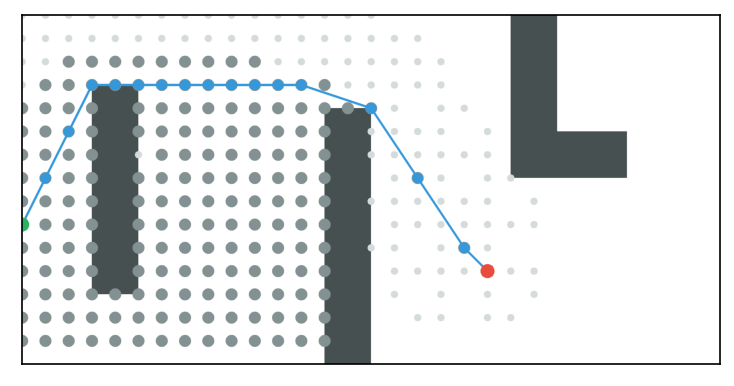

Path found! Length: 27.49579770596882. Nodes created: 2185. Number of steps: 172. Correct: False


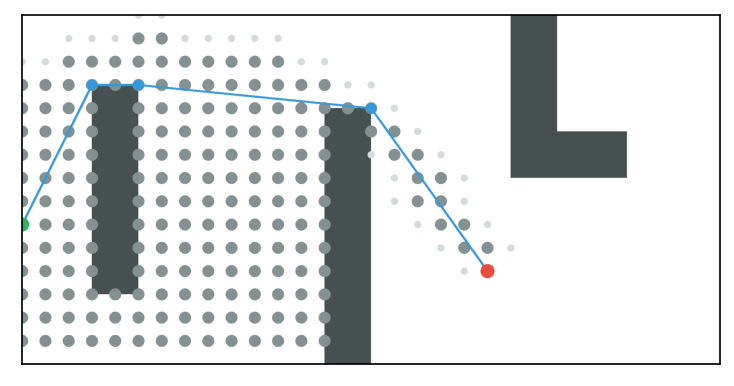

Path found! Length: 27.360404820662886. Nodes created: 366. Number of steps: 187. Correct: False


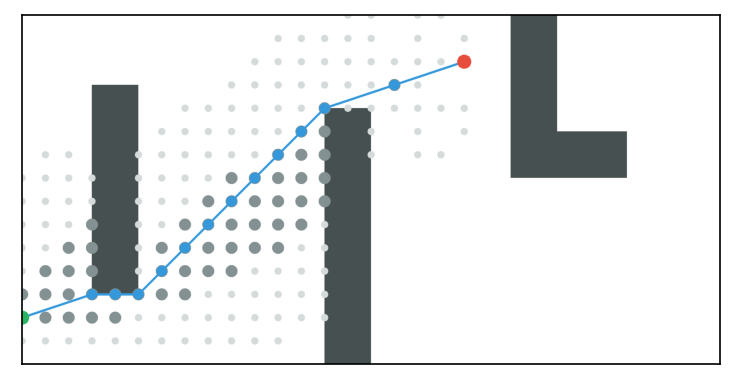

Path found! Length: 22.8005414794899. Nodes created: 949. Number of steps: 54. Correct: False


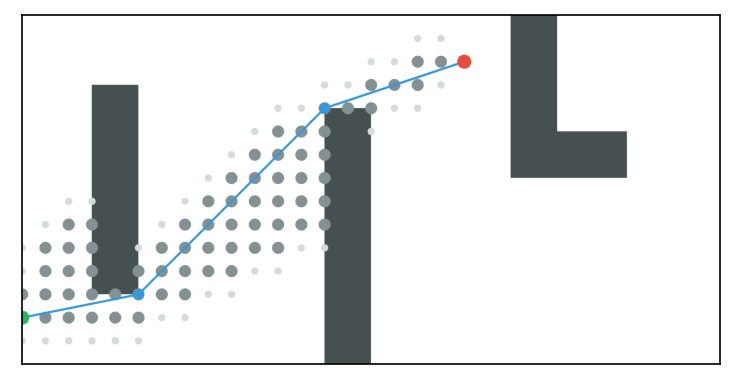

Path found! Length: 22.737283332914306. Nodes created: 153. Number of steps: 67. Correct: False


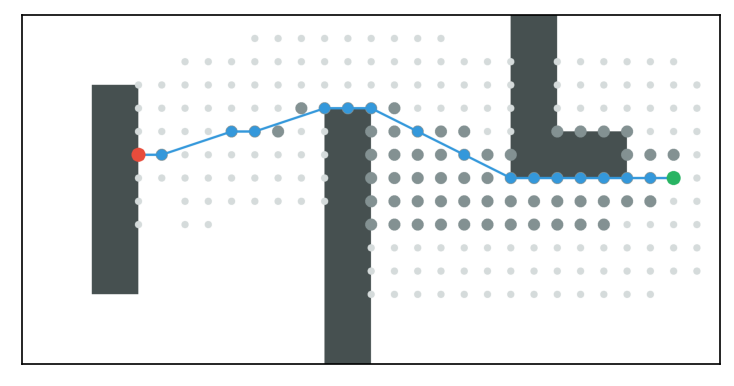

Path found! Length: 24.032759252836126. Nodes created: 1206. Number of steps: 67. Correct: False


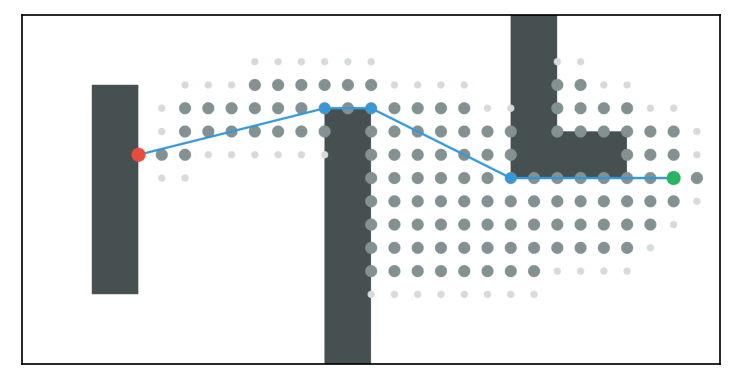

Path found! Length: 23.95441518373469. Nodes created: 257. Number of steps: 120. Correct: False


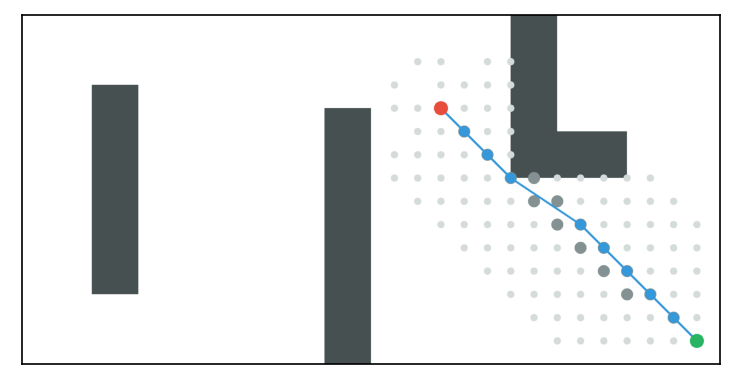

Path found! Length: 14.919259774448753. Nodes created: 363. Number of steps: 17. Correct: False


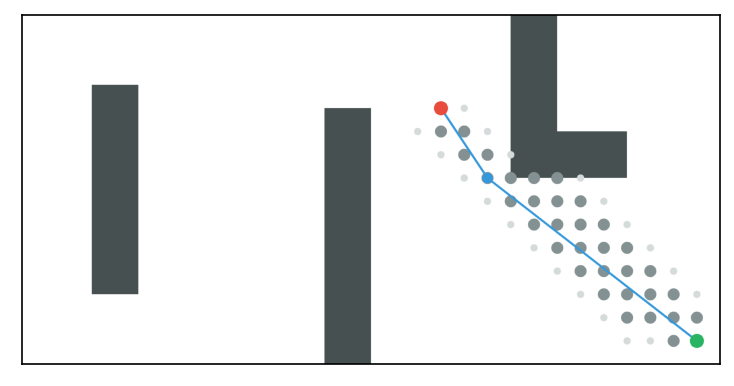

Path found! Length: 15.007305526455369. Nodes created: 84. Number of steps: 35. Correct: False


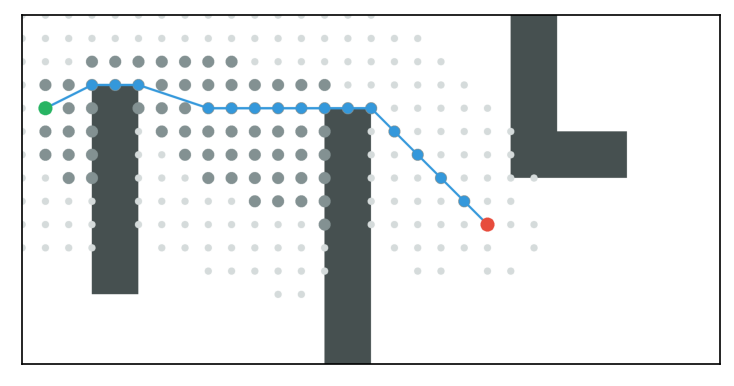

Path found! Length: 21.469413449533647. Nodes created: 1306. Number of steps: 73. Correct: False


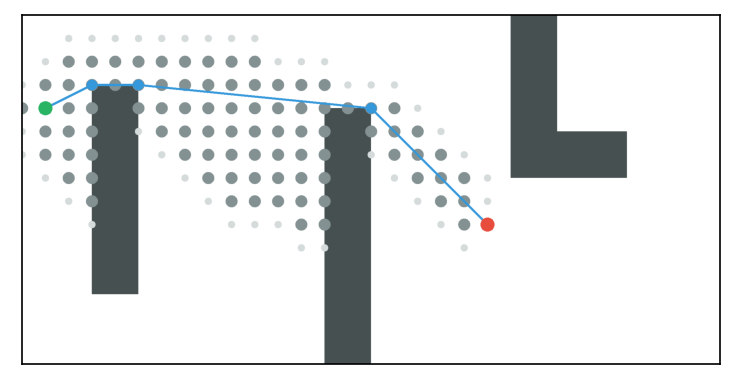

Path found! Length: 21.357011410486155. Nodes created: 197. Number of steps: 88. Correct: False


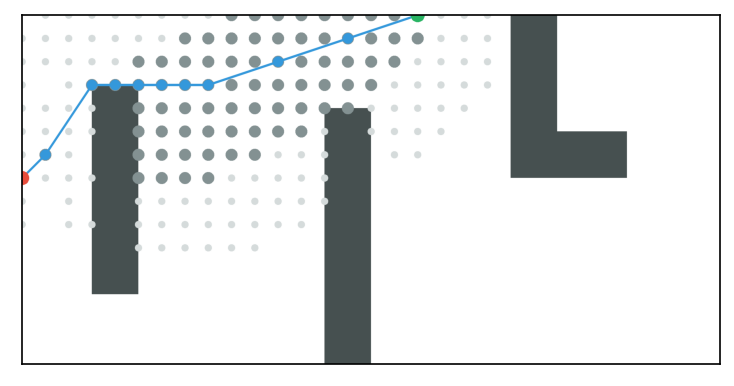

Path found! Length: 19.50659781834222. Nodes created: 1167. Number of steps: 75. Correct: False


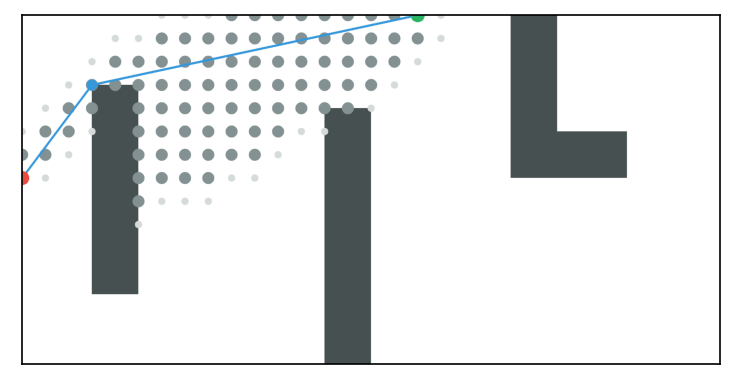

Path found! Length: 19.317821063276355. Nodes created: 174. Number of steps: 82. Correct: False


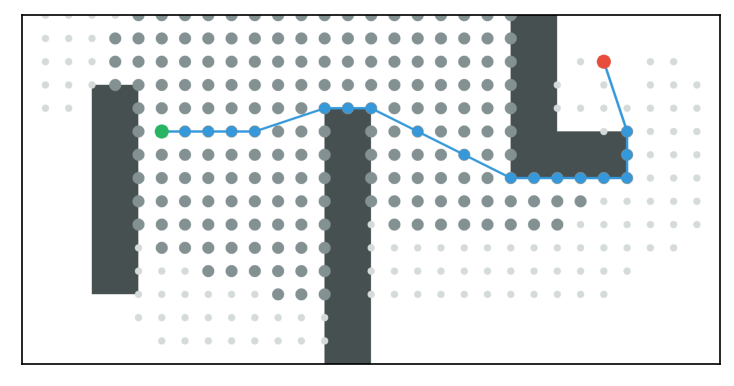

Path found! Length: 26.03275925283613. Nodes created: 2728. Number of steps: 197. Correct: False


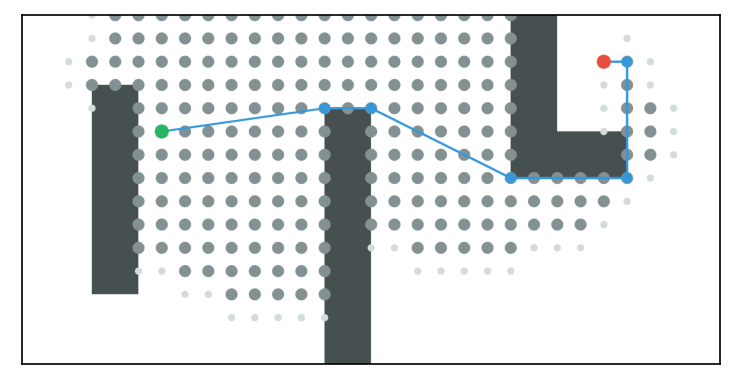

Path found! Length: 26.779271744364845. Nodes created: 431. Number of steps: 218. Correct: False


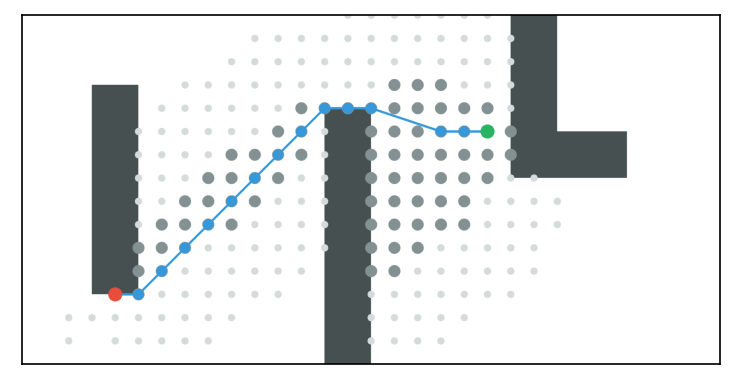

Path found! Length: 19.475986159153145. Nodes created: 1337. Number of steps: 72. Correct: False


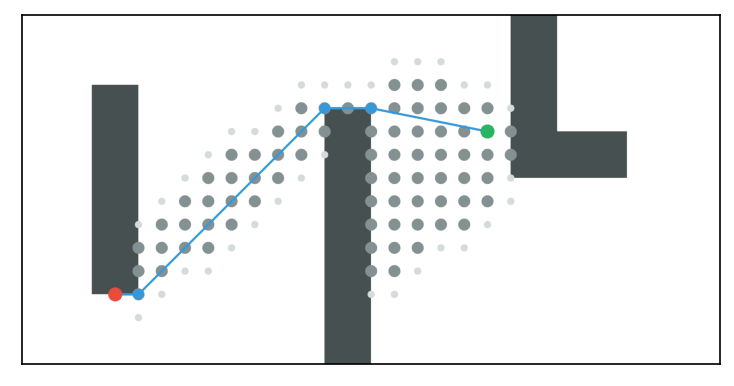

Path found! Length: 19.412728012577546. Nodes created: 169. Number of steps: 75. Correct: False


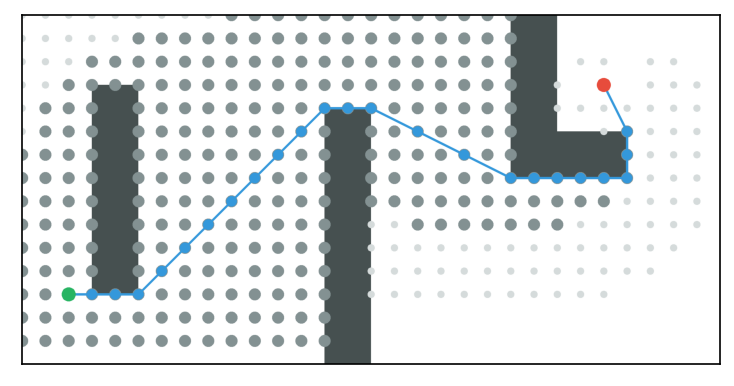

Path found! Length: 32.257980408983926. Nodes created: 3372. Number of steps: 268. Correct: False


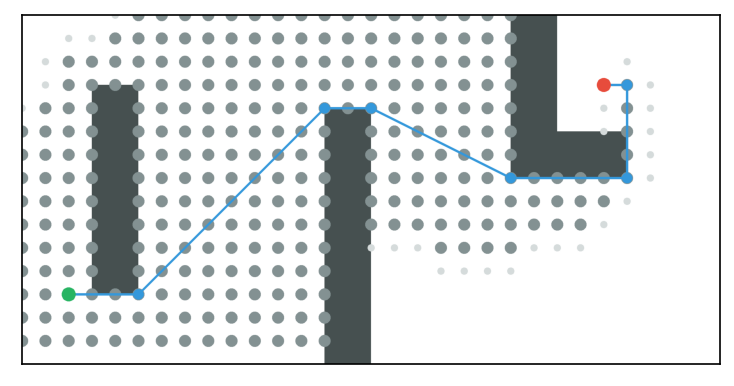

Path found! Length: 33.021912431484125. Nodes created: 540. Number of steps: 284. Correct: False


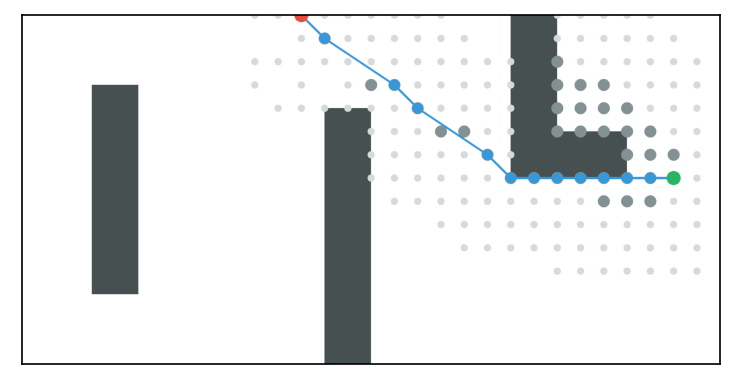

Path found! Length: 18.453743238047267. Nodes created: 618. Number of steps: 35. Correct: False


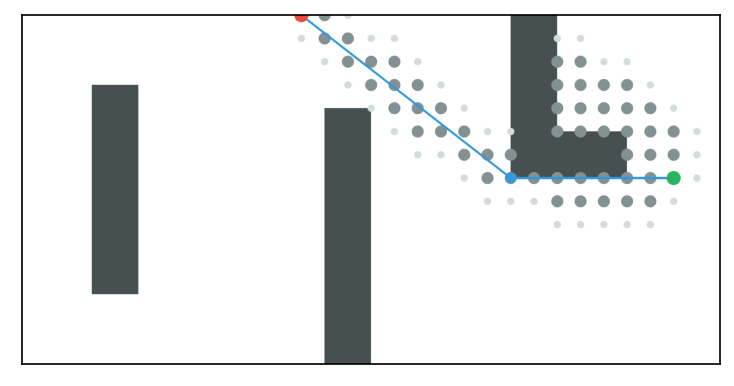

Path found! Length: 18.40175425099138. Nodes created: 123. Number of steps: 53. Correct: False


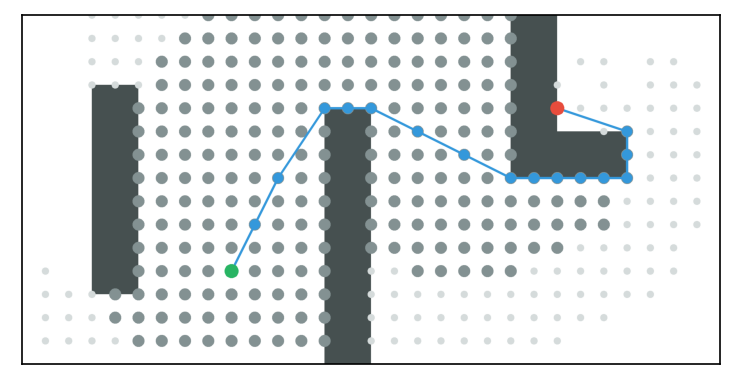

Path found! Length: 26.94816882313132. Nodes created: 3136. Number of steps: 235. Correct: False


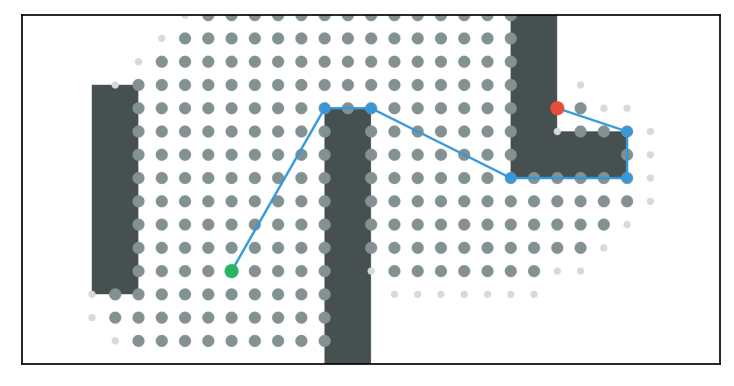

Path found! Length: 26.932739340966297. Nodes created: 471. Number of steps: 243. Correct: False


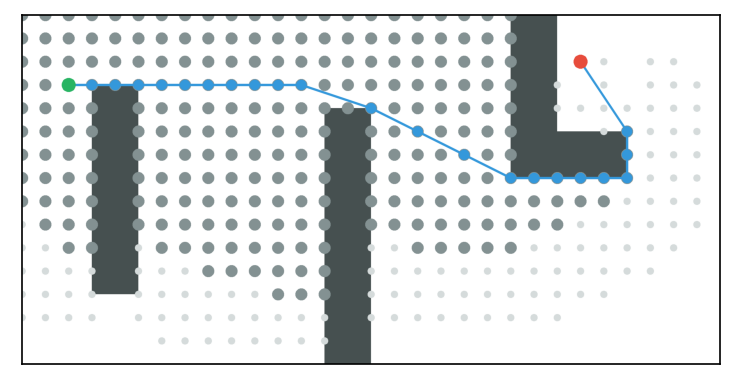

Path found! Length: 30.476032868131735. Nodes created: 3224. Number of steps: 246. Correct: False


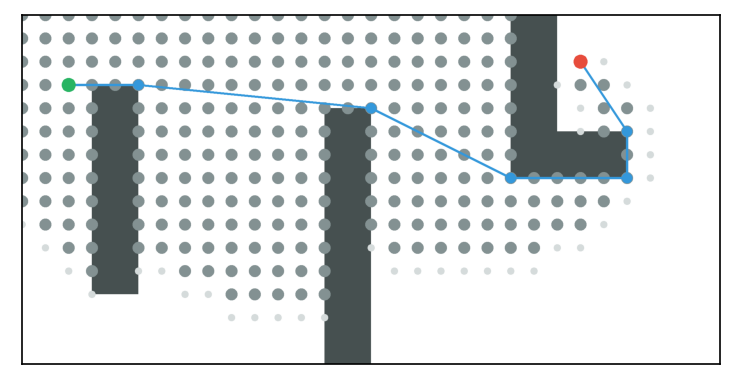

Path found! Length: 30.363630829084247. Nodes created: 502. Number of steps: 259. Correct: False


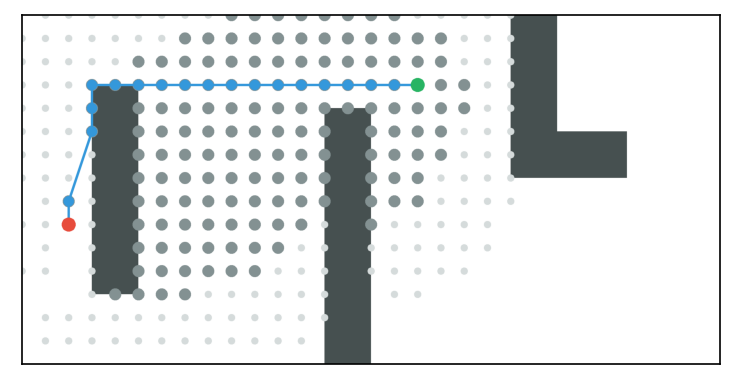

Path found! Length: 20.162277660168378. Nodes created: 2190. Number of steps: 146. Correct: False


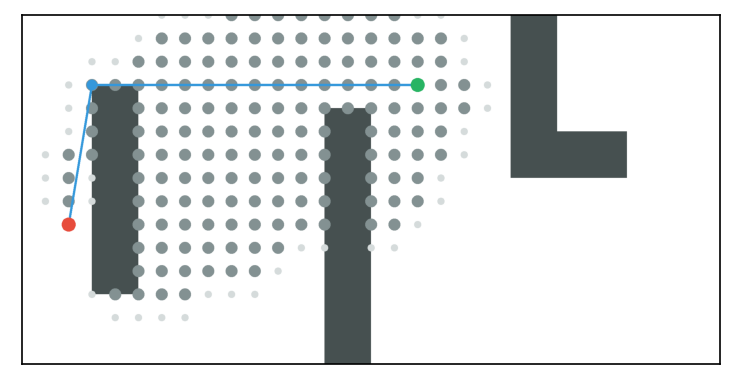

Path found! Length: 20.08276253029822. Nodes created: 312. Number of steps: 152. Correct: False


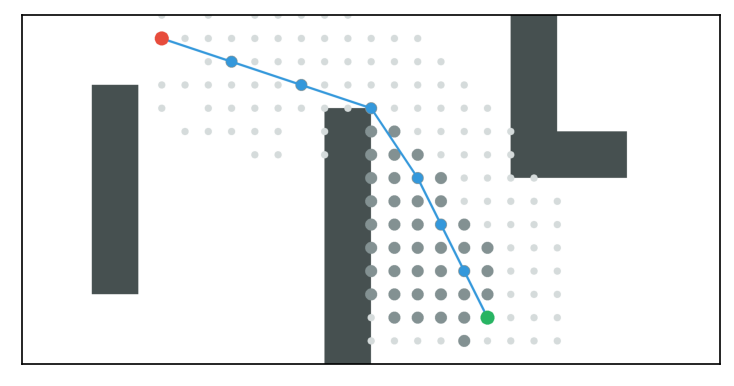

Path found! Length: 19.800588188468495. Nodes created: 769. Number of steps: 46. Correct: False


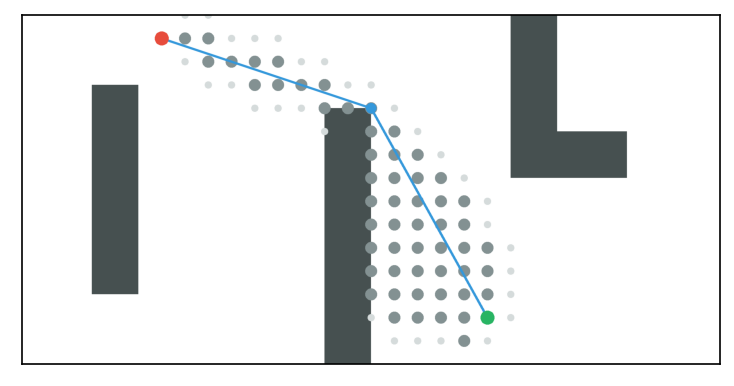

Path found! Length: 19.78246312149214. Nodes created: 130. Number of steps: 57. Correct: False


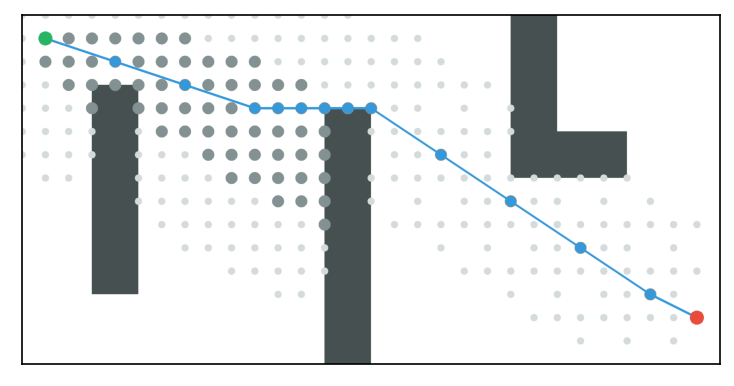

Path found! Length: 31.14510605986088. Nodes created: 1206. Number of steps: 68. Correct: False


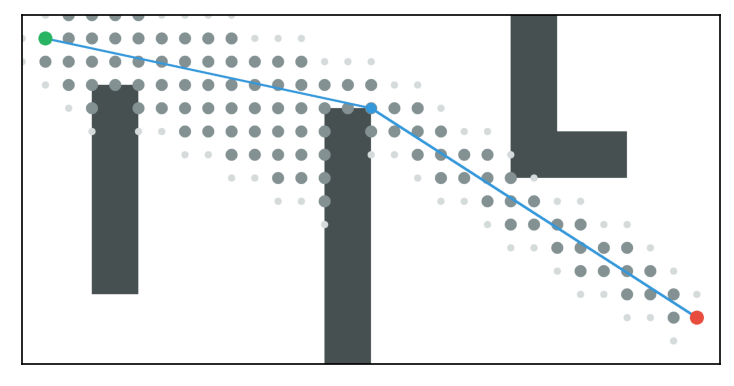

Path found! Length: 30.96113804036959. Nodes created: 234. Number of steps: 101. Correct: False


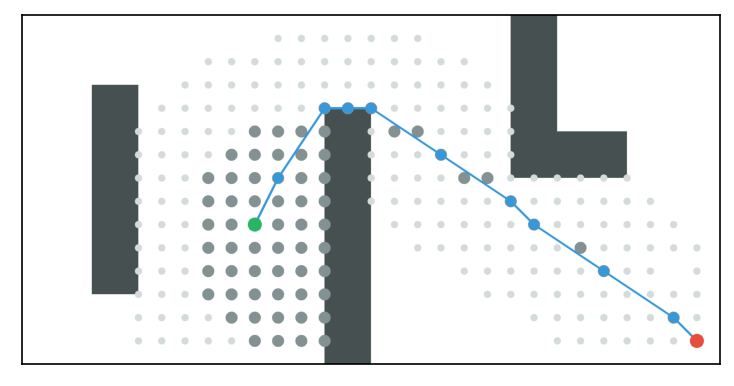

Path found! Length: 25.092251479565924. Nodes created: 1168. Number of steps: 68. Correct: False


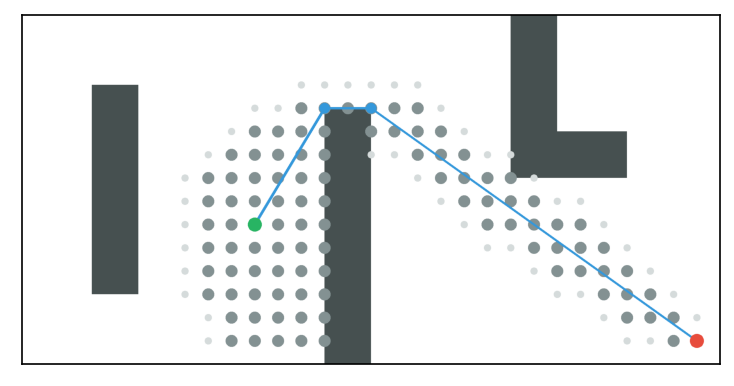

Path found! Length: 25.035602428930552. Nodes created: 216. Number of steps: 97. Correct: False


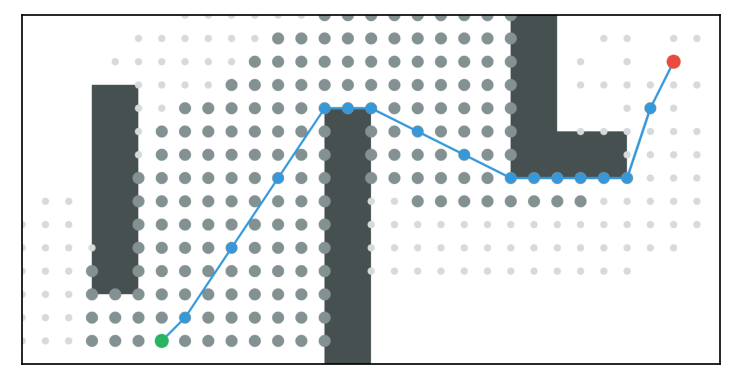

Path found! Length: 31.3374169589326. Nodes created: 2585. Number of steps: 191. Correct: False


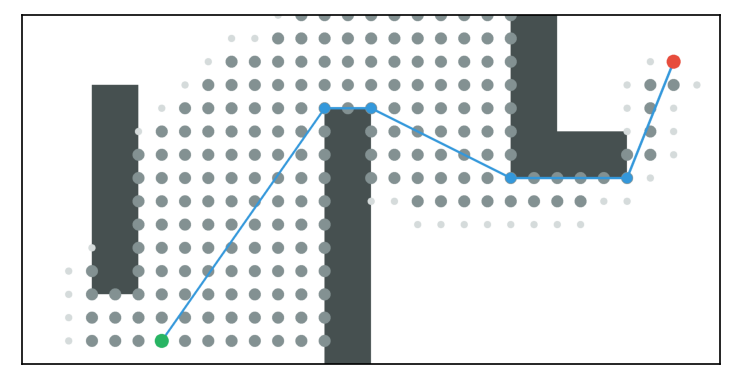

Path found! Length: 31.299924355367576. Nodes created: 393. Number of steps: 200. Correct: False


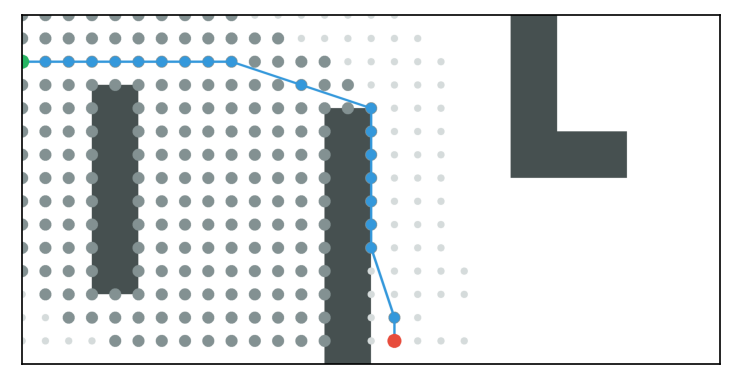

Path found! Length: 25.486832980505138. Nodes created: 2406. Number of steps: 200. Correct: False


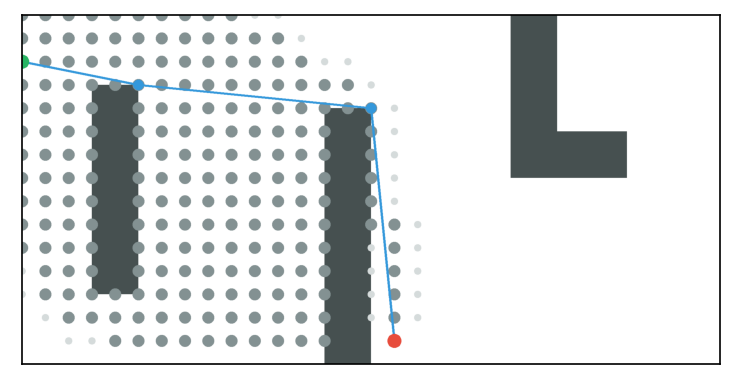

Path found! Length: 25.198770755834566. Nodes created: 385. Number of steps: 201. Correct: False


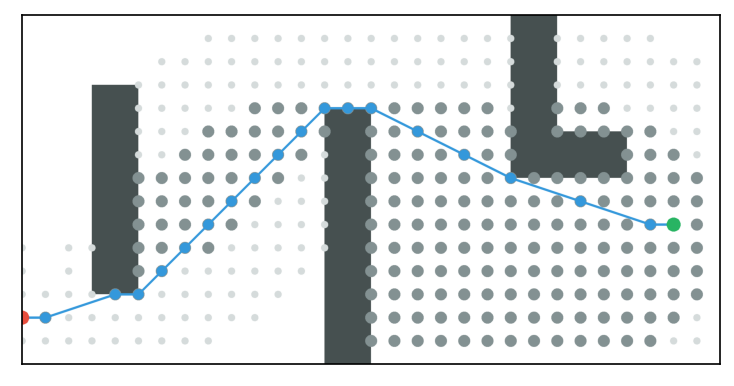

Path found! Length: 32.508745411989274. Nodes created: 2779. Number of steps: 193. Correct: False


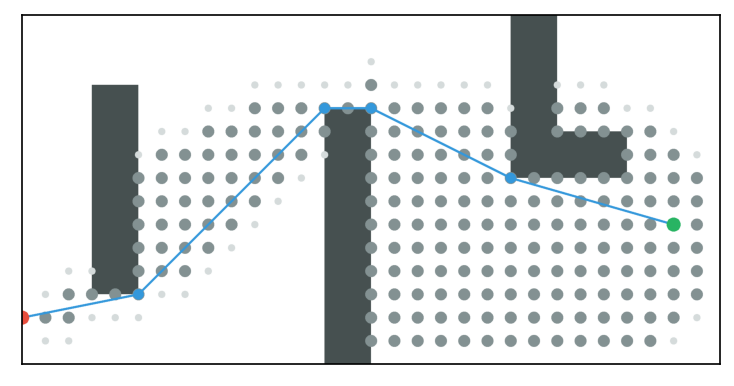

Path found! Length: 32.401041834357436. Nodes created: 403. Number of steps: 199. Correct: False


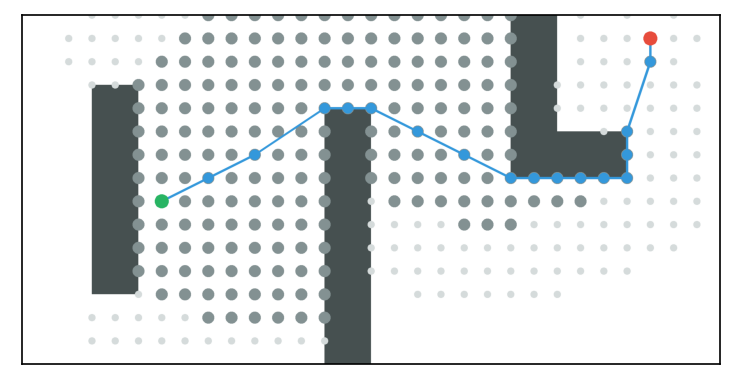

Path found! Length: 27.94816882313132. Nodes created: 2732. Number of steps: 198. Correct: False


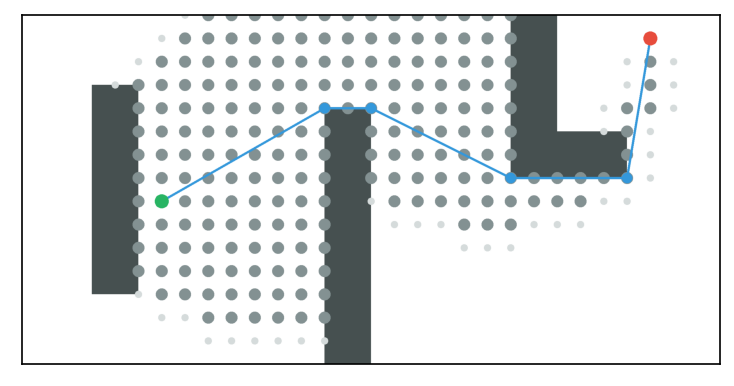

Path found! Length: 27.853224211096137. Nodes created: 400. Number of steps: 201. Correct: False


In [9]:
for i in range(20):
    simple_test(astar2k, i, uf.euclidian_distance, Open, Closed, 5)
    simple_test(thetastar, i, uf.euclidian_distance, Open, Closed)

In [10]:
"""def astar_reexpansion(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, open_and_closed_type = YourOpenAndClosed):
    start_node = Node(i = start_i, j = start_j)
    OPEN_AND_CLOSED = open_and_closed_type()
    steps = 0
    nodes_created = 0

    OPEN_AND_CLOSED.add_node(start_node)
    while not OPEN_AND_CLOSED.is_empty():
        current = OPEN_AND_CLOSED.get_best_node()
        steps += 1
        if (current.i == goal_i and current.j == goal_j):
            return (True, current, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded)
        for (neighbour_i, neighbour_j) in grid_map.get_neighbors(current.i, current.j):
            next_node = Node(i = neighbour_i, j = neighbour_j, g = current.g + compute_cost(current.i, current.j, neighbour_i, neighbour_j), h = heuristic_func(neighbour_i, neighbour_j, goal_i, goal_j), parent = current, k = nodes_created)
            nodes_created += 1
            OPEN_AND_CLOSED.add_node(next_node)

    return (False, None, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded)
"""

'def astar_reexpansion(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, open_and_closed_type = YourOpenAndClosed):\n    start_node = Node(i = start_i, j = start_j)\n    OPEN_AND_CLOSED = open_and_closed_type()\n    steps = 0\n    nodes_created = 0\n\n    OPEN_AND_CLOSED.add_node(start_node)\n    while not OPEN_AND_CLOSED.is_empty():\n        current = OPEN_AND_CLOSED.get_best_node()\n        steps += 1\n        if (current.i == goal_i and current.j == goal_j):\n            return (True, current, steps, nodes_created, OPEN_AND_CLOSED, OPEN_AND_CLOSED.expanded, OPEN_AND_CLOSED.reexpanded)\n        for (neighbour_i, neighbour_j) in grid_map.get_neighbors(current.i, current.j):\n            next_node = Node(i = neighbour_i, j = neighbour_j, g = current.g + compute_cost(current.i, current.j, neighbour_i, neighbour_j), h = heuristic_func(neighbour_i, neighbour_j, goal_i, goal_j), parent = current, k = nodes_created)\n            nodes_created += 1\n            OPEN_AND_CLOS

In [11]:
for i in range(20):
    #res = simple_test(astar_reexpansion, i, euclidian_distance, YourOpenAndClosed)
    #print("Number of reexpansions:", res[4].number_of_reexpansions)
    pass